In [ ]:
#librerias necesarias
import pandas as pd
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from skimage.feature import graycomatrix, graycoprops
import cv2
from skimage.color import rgb2gray
from tqdm import tqdm
from PIL import Image
from skimage.feature import local_binary_pattern




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#PROCESAMIENTO

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/movie_project/movies_posters.csv")
print("Tamaño del dataset:", df.shape)
df.head()


Tamaño del dataset: (19715, 9)


,imdbId,Imdb Link,Title,IMDB Score,Poster,movieId,tmdbId,title,genres
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,https://images-na.ssl-images-amazon.com/images...,1,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,https://images-na.ssl-images-amazon.com/images...,2,8844,Jumanji (1995),Adventure|Children|Fantasy
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,https://images-na.ssl-images-amazon.com/images...,3,15602,Grumpier Old Men (1995),Comedy|Romance
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,https://images-na.ssl-images-amazon.com/images...,4,31357,Waiting to Exhale (1995),Comedy|Drama|Romance
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,https://images-na.ssl-images-amazon.com/images...,5,11862,Father of the Bride Part II (1995),Comedy


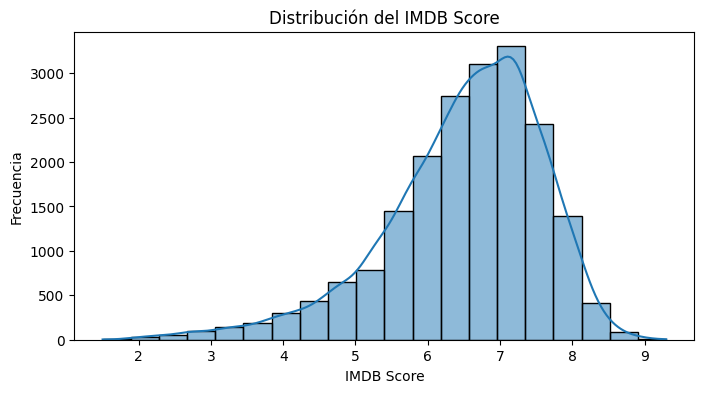

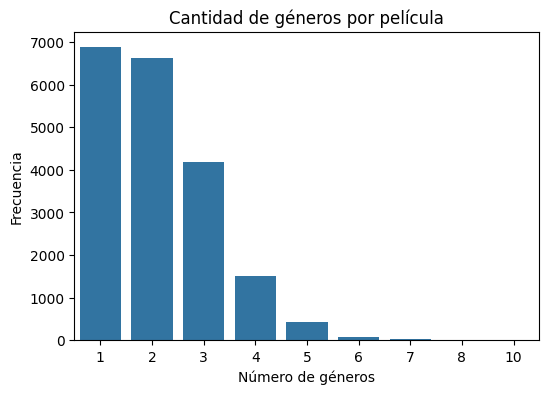

In [ ]:

# Histograma del IMDB Score
plt.figure(figsize=(8, 4))
sns.histplot(df["IMDB Score"], bins=20, kde=True)
plt.title("Distribución del IMDB Score")
plt.xlabel("IMDB Score")
plt.ylabel("Frecuencia")
plt.show()

# Cantidad de géneros por película
df["genre_count"] = df["genres"].apply(lambda x: len(x.split("|")))

plt.figure(figsize=(6, 4))
sns.countplot(x="genre_count", data=df)
plt.title("Cantidad de géneros por película")
plt.xlabel("Número de géneros")
plt.ylabel("Frecuencia")
plt.show()


count    19715.000000
mean         6.502592
std          1.101349
min          1.500000
25%          5.900000
50%          6.700000
75%          7.300000
max          9.300000
Name: IMDB Score, dtype: float64


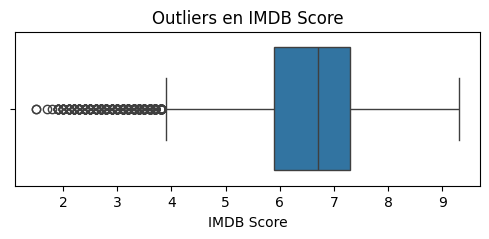

Poster    40
dtype: int64


In [ ]:
#Identificar y manejar outliers
print(df["IMDB Score"].describe())
plt.figure(figsize=(6, 2))
sns.boxplot(x=df["IMDB Score"])
plt.title("Outliers en IMDB Score")
plt.show()

print(df.isnull().sum()[df.isnull().sum() > 0])


vemos que en el atributo de Posters ,al tener 40 valores nulos ,es decir las peliculas que contienen a los posters vacios no se podran utilizar para el clustering ,asi que eliminamos

In [ ]:
df = df.dropna(subset=["Poster"])
print(f"Películas restantes después de eliminar sin póster: {df.shape[0]}")
df.to_csv("/content/drive/MyDrive/movie_project/posters_clean.csv", index=False)


Películas restantes después de eliminar sin póster: 19675


In [ ]:
#eliminamos las imagenes que no corresponden con las peliculas
poster_folder = "/content/drive/MyDrive/movie_project/SampleMoviePosters"
df = pd.read_csv("/content/drive/MyDrive/movie_project/posters_clean.csv")
valid_tmdb_ids = set(df["tmdbId"].astype(int))

# Recorremos y eliminamos las imágenes no válidas
deleted = 0
for filename in os.listdir(poster_folder):
    if filename.endswith(".jpg"):
        tmdb_id = int(filename.split(".")[0])
        if tmdb_id not in valid_tmdb_ids:
            os.remove(os.path.join(poster_folder, filename))
            deleted += 1
print(f"Imágenes eliminadas: {deleted}")

Imágenes eliminadas: 0


In [ ]:
#verificamos que imagenes no corresponden con la pelicula

df = pd.read_csv("/content/drive/MyDrive/movie_project/posters_clean.csv")

# Verifica imágenes físicas en carpeta
poster_folder = "/content/drive/MyDrive/movie_project/SampleMoviePosters"
poster_files = os.listdir(poster_folder)
poster_ids = {int(f.split(".")[0]) for f in poster_files if f.endswith(".jpg")}

# Chequeo 1: Todas las tmdbId del dataset tienen su imagen
missing = df[~df["tmdbId"].isin(poster_ids)]
print(f"Peliculas en CSV sin imagen fisica: {missing.shape[0]}")

# Chequeo 2: Todas las imágenes corresponden a tmdbId del dataset
extra_imgs = poster_ids - set(df["tmdbId"])
print(f"Imagenes extra sin pelicula correspondiente: {len(extra_imgs)}")


Peliculas en CSV sin imagen fisica: 0
Imagenes extra sin pelicula correspondiente: 0


In [ ]:
# Cargar el CSV limpio
df = pd.read_csv("/content/drive/MyDrive/movie_project/posters_clean.csv")

# Directorio con imágenes
poster_folder = "/content/drive/MyDrive/movie_project/SampleMoviePosters"

# Agregar la ruta completa de la imagen a cada película
df["image_path"] = df["tmdbId"].apply(lambda x: f"{poster_folder}/{int(x)}.jpg")

# Verificamos que exista el archivo
df = df[df["image_path"].apply(os.path.exists)]

print("Total de imágenes encontradas:", df.shape[0])


Total de imágenes encontradas: 19669


Unimos las películas del dataset con sus imágenes de póster usando el tmdbId como identificador, construyendo la ruta a cada imagen y verificando si realmente existe el archivo en la carpeta. Luego filtramos el dataset para quedarnos solo con las películas que tienen una imagen disponible.

In [ ]:
tmdb_ids = df["tmdbId"].dropna().astype(int).astype(str)
# Crear columna con la ruta completa de la imagen
df["image_path"] = df["tmdbId"].apply(lambda x: f"{poster_folder}/{int(x)}.jpg")

# Filtrar solo las películas con imagen existente
df = df[df["image_path"].apply(os.path.exists)]

# Verifica
print("Total de imágenes disponibles:", df.shape[0])
df[["tmdbId", "image_path"]].head()


Total de imágenes disponibles: 19675


,tmdbId,image_path
0,862,/content/drive/MyDrive/movie_project/SampleMov...
1,8844,/content/drive/MyDrive/movie_project/SampleMov...
2,15602,/content/drive/MyDrive/movie_project/SampleMov...
3,31357,/content/drive/MyDrive/movie_project/SampleMov...
4,11862,/content/drive/MyDrive/movie_project/SampleMov...


In [ ]:
def contar_imagenes_corruptas(df, folder_col="image_path"):
    corruptas = []
    for path in tqdm(df[folder_col]):
        try:
            with Image.open(path) as img:
                img.verify()
        except:
            corruptas.append(path)
    return corruptas

# Cargar dataset limpio con rutas
df = pd.read_csv("/content/drive/MyDrive/movie_project/posters_clean.csv")
poster_folder = "/content/drive/MyDrive/movie_project/SampleMoviePosters"
df["image_path"] = df["tmdbId"].apply(lambda x: f"{poster_folder}/{int(x)}.jpg")

# Contar imágenes corruptas
imagenes_corruptas = contar_imagenes_corruptas(df)

# Mostrar resultados
print(f"\n Total de imagenes corruptas: {len(imagenes_corruptas)}")
print("\n Lista de imagenes corruptas:")
for path in imagenes_corruptas:
    print(path)



  0%|          | 0/19669 [00:00<?, ?it/s]

In [ ]:

imagenes_corruptas = [
    "/content/drive/MyDrive/movie_project/SampleMoviePosters/13203.jpg",
    "/content/drive/MyDrive/movie_project/SampleMoviePosters/9415.jpg",
    "/content/drive/MyDrive/movie_project/SampleMoviePosters/28736.jpg",
    "/content/drive/MyDrive/movie_project/SampleMoviePosters/1777.jpg",
    "/content/drive/MyDrive/movie_project/SampleMoviePosters/30230.jpg",
    "/content/drive/MyDrive/movie_project/SampleMoviePosters/41009.jpg"
]

# Eliminar del disco
for path in imagenes_corruptas:
    try:
        os.remove(path)
        print(f" Eliminada: {path}")
    except Exception as e:
        print(f" Error eliminando {path}: {e}")

# Cargar dataset limpio
df = pd.read_csv("/content/drive/MyDrive/movie_project/posters_clean.csv")

# Reconstruir rutas
poster_folder = "/content/drive/MyDrive/movie_project/SampleMoviePosters"
df["image_path"] = df["tmdbId"].apply(lambda x: f"{poster_folder}/{int(x)}.jpg")

# Filtrar DataFrame
df_filtrado = df[~df["image_path"].isin(imagenes_corruptas)].copy()

# Guardar CSV actualizado
df_filtrado.to_csv("/content/drive/MyDrive/movie_project/posters_clean.csv", index=False)
print(f"\n Nuevo CSV guardado. Películas restantes: {df_filtrado.shape[0]}")


 Error eliminando /content/drive/MyDrive/movie_project/SampleMoviePosters/13203.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/movie_project/SampleMoviePosters/13203.jpg'
 Error eliminando /content/drive/MyDrive/movie_project/SampleMoviePosters/9415.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/movie_project/SampleMoviePosters/9415.jpg'
 Error eliminando /content/drive/MyDrive/movie_project/SampleMoviePosters/28736.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/movie_project/SampleMoviePosters/28736.jpg'
 Error eliminando /content/drive/MyDrive/movie_project/SampleMoviePosters/1777.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/movie_project/SampleMoviePosters/1777.jpg'
 Error eliminando /content/drive/MyDrive/movie_project/SampleMoviePosters/30230.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/movie_project/SampleMoviePosters/30230.jpg'
 Error eliminando /content/drive/MyDrive/movie_project

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/movie_project/posters_clean.csv")
print("Tamaño del dataset:", df.shape)
df.head()

Tamaño del dataset: (19669, 10)


,imdbId,Imdb Link,Title,IMDB Score,Poster,movieId,tmdbId,title,genres,image_path
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,https://images-na.ssl-images-amazon.com/images...,1,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,/content/drive/MyDrive/movie_project/SampleMov...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,https://images-na.ssl-images-amazon.com/images...,2,8844,Jumanji (1995),Adventure|Children|Fantasy,/content/drive/MyDrive/movie_project/SampleMov...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,https://images-na.ssl-images-amazon.com/images...,3,15602,Grumpier Old Men (1995),Comedy|Romance,/content/drive/MyDrive/movie_project/SampleMov...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,https://images-na.ssl-images-amazon.com/images...,4,31357,Waiting to Exhale (1995),Comedy|Drama|Romance,/content/drive/MyDrive/movie_project/SampleMov...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,https://images-na.ssl-images-amazon.com/images...,5,11862,Father of the Bride Part II (1995),Comedy,/content/drive/MyDrive/movie_project/SampleMov...


Antes de hacer la etracción de caracteristicas se verifico primero que las imagenes eistentes no sean corruptas ,ya que sino habria un problema al momento de la etraccion y serian imagenes que estarian haciendo ruido después para el clustering ,como vemos se tienen  imagenes corruptas asi que debemos eliminarlos


##Extraccón de  características visuales

In [ ]:
def extract_features_hsv_lbp(image_path):
    try:
        # Abrir y convertir imagen a RGB
        img = Image.open(image_path).convert("RGB")
        img = img.resize((128, 128))  # tamaño estándar
        img_np = np.array(img)

        ### 1. Histograma de color HSV ###
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        hist_h = cv2.calcHist([hsv], [0], None, [32], [0, 180])
        hist_s = cv2.calcHist([hsv], [1], None, [32], [0, 256])
        hist_v = cv2.calcHist([hsv], [2], None, [32], [0, 256])
        hist_hsv = np.concatenate([hist_h, hist_s, hist_v]).flatten()
        hist_hsv = hist_hsv / np.sum(hist_hsv)  # normalizar

        ### 2. Textura con LBP ###
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
        (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= lbp_hist.sum()  # normalizar

        # Unir ambos vectores
        features = np.concatenate([hist_hsv, lbp_hist])

        return features

    except Exception as e:
        print(f" Error procesando {image_path}: {e}")
        return None

In [ ]:

tmdb_id = int(df.iloc[0]["tmdbId"])
img_path = f"{poster_folder}/{tmdb_id}.jpg"

features = extract_features_hsv_lbp(img_path)

if features is not None:
    print(" Extraccion correcta")
    print(" Dimension del vector:", features.shape)
    print(" Primeros valores:", features[:10])
else:
    print(" Fall0 la extraccion de caracteristicas")


 Extracción correcta
 Dimensión del vector: (105,)
 Primeros valores: [0.01346842 0.03428141 0.02372233 0.01839193 0.0144043  0.00203451
 0.00242106 0.00315348 0.00394694 0.00402832]


Vemos que funcionó para una imagen ,entonces aplicamos para todos

In [ ]:
all_features = []
ids_validos = []

print(" Extrayendo características de todas las imágenes...\n")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_features_hsv_lbp(row["image_path"])
    if features is not None:
        all_features.append(features)
        ids_validos.append(row["tmdbId"])

# Convertir a DataFrame
features_array = np.array(all_features)
columns = [f"feat_{i}" for i in range(features_array.shape[1])]
df_features = pd.DataFrame(features_array, columns=columns)
df_features.insert(0, "tmdbId", ids_validos)


 Extrayendo características de todas las imágenes...



100%|██████████| 19669/19669 [2:18:45<00:00,  2.36it/s]


In [ ]:

#  Guardar CSV de las caracteristicas
output_path = "/content/drive/MyDrive/movie_project/poster_features.csv"
df_features.to_csv(output_path, index=False)
print(f"\n Caracteristicas extraidas exitosamente. Guardadas en: {output_path}")
print(f" Total de peliculas procesadas: {len(df_features)}")


 Caracteristicas extraidas exitosamente. Guardadas en: /content/drive/MyDrive/movie_project/poster_features.csv
 Total de peliculas procesadas: 19669
